In [17]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.svm import OneClassSVM
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from collections import defaultdict
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import itertools
import logging
import pickle

In [2]:
df = pd.read_csv("../data/run-over-dataset.csv")
print(df.shape)

columns_to_drop = ['VERBALE', 'DATA', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro',
                    'Totale', 'Tot Volta cranica', 'Tot Base cranica', 
                    'Tot Neuroc.', 'Tot Splancnoc.', 'Tot Testa',
                    'Tot Tratto toracico', 'Tot Tratto lombare', 'Tot Rachide',
                    ' Totale coste', 'Sterno in toto', 'Tot Bacino', 'I costa dx', 'II costa dx',
                    'III costa dx', 'IV costa dx', 'V costa dx', 'VI costa dx', 'VII costa dx', 
                    'VIII costa dx', 'IX costa dx', 'X costa dx', 'XI costa dx', 'XII costa dx',
                    'I costa sx', 'II costa sx', 'III costa sx', 'IV costa sx', 'V costa sx', 
                    'VI costa sx', 'VII costa sx', 'VIII costa sx', 'IX costa sx', 
                    'X costa sx', 'XI costa sx', 'XII costa sx']

X = df.drop(columns=columns_to_drop)
print(X.shape)

X['ALTEZZA'] = [int(float(h.replace(',', '.'))*100) for h in X['ALTEZZA']]
X['PESO'] = [int(float(str(h).replace(',', '.'))) for h in X['PESO']]
X['BMI'] = [float(str(h).replace(',', '.')) for h in X['BMI']]

num_unique_values = X.nunique()
constant_columns = num_unique_values[num_unique_values == 1].index.tolist()

X = X.drop(columns=constant_columns)
X = X.T.drop_duplicates().T
print(X.shape)

(130, 367)
(130, 326)
(130, 274)


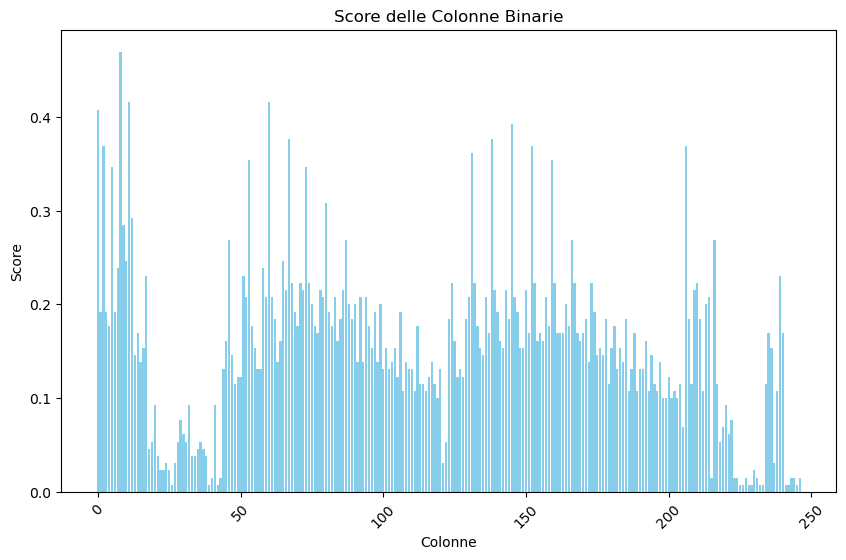

In [3]:
def plot_columns(X):
    X = X.drop(columns='Mezzo')

    binary_columns = [col for col in X.columns if set(X[col].unique()).issubset({0, 1})]
    X = X[binary_columns]

    columns = []
    column_scores = []

    for col in X.columns:
        n1 = sum([1 if x == 1 else 0 for x in X[col]])
        n0 = sum([1 if x == 0 else 0 for x in X[col]])

        columns.append(col)
        column_scores.append(n1 / (n1 + n0))

    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(0, len(column_scores)), column_scores, color='skyblue')
    plt.xlabel('Colonne')
    plt.ylabel('Score')
    plt.title('Score delle Colonne Binarie')
    plt.xticks(rotation=45)
    plt.show()

    return

plot_columns(X)


In [4]:
def filter_columns(X, score_threshold):
    binary_columns = [col for col in X.columns if set(X[col].unique()).issubset({0, 1})]
    filtered_columns = [col for col in X.columns if not(set(X[col].unique()).issubset({0, 1}))]
    X_binary = X[binary_columns]

    for col in X_binary.columns:
        n1 = sum(X_binary[col])
        n0 = len(X_binary[col]) - n1
        column_score = n1 / (n1 + n0)

        if column_score >= score_threshold:
            filtered_columns.append(col)

    filtered_df = X[filtered_columns]

    return filtered_df.values

In [5]:
random_seed = 3355825

In [6]:
def add_record(df, record):
    new_record = pd.DataFrame(record, index=[0])
    df = pd.concat([df, new_record], ignore_index=True)
    return df  

In [7]:
def nested_cv_svm(X, random_seed, threshold, decomposition=PCA, n_outer_folds=7, n_inner_folds=5, n_components=65, mod_selection_score=accuracy_score, positive_class=0):
    kernels = ['linear', 'rbf']
    gammas = np.logspace(-3, 3, 7)
    nus = np.linspace(0.01, 0.50, 25) 
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
    
    best_params = {'kernel': '', 'gamma': 0, 'nu': 0, 'components': 0, 'scaler': ''}
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    best_overall_accuracy = 0
    best_overall_params = {'kernel': '', 'gamma': 0, 'nu': 0, 'components': 0, 'scaler': ''}

    y = X['Mezzo'].values
    y = np.array([0. if x == positive_class else 1. for x in y], dtype=float)
    
    X = X.drop(columns='Mezzo')
    X = filter_columns(X, threshold)

    outer_cv = StratifiedKFold(n_splits=n_outer_folds, shuffle=True, random_state=random_seed)
        
    for outer_cv_number, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = StratifiedKFold(n_splits=n_inner_folds, shuffle=True, random_state=random_seed)

        best_score = 0
        best_scaler = None
        best_encoder = None
        for inner_cv_number, (trainval_idx, valid_idx) in enumerate(inner_cv.split(X_train, y_train)):
            for kernel in kernels:
                param_combinations = itertools.product([kernel], gammas, nus, scalers)
                
                if kernel == 'linear':
                    param_combinations = itertools.product(['linear'], [0.001], nus, scalers)
                elif kernel == 'rbf':
                    param_combinations = itertools.product(['rbf'], gammas, nus, scalers)

                for params in param_combinations:
                    scaler = params[3]
                    X_trainval, X_valid = X_train[trainval_idx], X_train[valid_idx]
                    y_trainval, y_valid = y_train[trainval_idx], y_train[valid_idx]

                    X_trainval_scaled = scaler.fit_transform(X_trainval)
                    X_valid_scaled = scaler.transform(X_valid)

                    encoder = decomposition(n_components=n_components)
                    encoder.fit(X_train)
                    
                    X_trainval_reduced = encoder.transform(X_trainval_scaled)
                    X_valid_reduced = encoder.transform(X_valid_scaled)
                        
                    idxs_neg = np.where(y_trainval == 1)[0]
                
                    X_trainval_reduced = np.delete(X_trainval_reduced, idxs_neg, axis=0)
                    y_trainval = np.delete(y_trainval, idxs_neg)

                    clf = OneClassSVM(kernel=params[0], gamma=params[1], nu=params[2])
                        
                    clf.fit(X_trainval_reduced)
                        
                    pred_values = clf.predict(X_valid_reduced)
                    true_values = [1 if y == 0 else -1 for y in y_valid]
                        
                    score = mod_selection_score(true_values, pred_values)
                    curr_params = {
                            'kernel': params[0],
                            'gamma': params[1],
                            'nu': params[2],
                            'components': n_components,
                            'scaler': params[3]
                    }

                    logging.info(f"inner cv number: {inner_cv_number}, {mod_selection_score.__name__}: {score}, with params: {curr_params}")
                            
                    if score > best_score:
                        best_score = score
                        best_encoder = encoder
                        best_scaler = scaler
                        best_params = curr_params

        idxs_neg = np.where(y_train == 1)[0]
        X_train = np.delete(X_train, idxs_neg, axis=0)
        y_train = np.delete(y_train, idxs_neg)

        X_train_scaled = best_scaler.fit_transform(X_train)
        X_test_scaled = best_scaler.transform(X_test)

        X_train_reduced = best_encoder.transform(X_train_scaled)
        X_test_reduced = best_encoder.transform(X_test_scaled)

        clf = OneClassSVM(kernel=best_params['kernel'], gamma=best_params['gamma'], nu=best_params['nu'])
        clf.fit(X_train_reduced)

        pred_values = clf.predict(X_test_reduced)
        true_values = [1 if y == 0 else -1 for y in y_test]

        accuracy = accuracy_score(true_values, pred_values)
        precision = precision_score(true_values, pred_values, zero_division=0.0)
        recall = recall_score(true_values, pred_values)
        f1 = f1_score(true_values, pred_values)

        if accuracy > best_overall_accuracy:
            best_overall_accuracy = accuracy
            best_overall_params = best_params

        logging.info(f"outer cv number: {outer_cv_number}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1} with params: {best_params}")

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    return {
        'algorythm': 'OneClassSVM',
        'best kernel': best_overall_params['kernel'],
        'best gamma': best_overall_params['gamma'],
        'best nu': best_overall_params['nu'],
        'n_components': best_overall_params['components'],
        'best scaler': best_overall_params['scaler'],
        'score used for model selection': mod_selection_score.__name__,
        'method used for model selection': 'nested cv',
        'accuracy mean': np.mean(accuracy_scores) * 100,
        'accuracy std': np.std(accuracy_scores) * 100,
        'precision mean': np.mean(precision_scores) * 100,
        'precision std': np.std(precision_scores) * 100,
        'recall mean': np.mean(recall_scores) * 100,
        'recall std': np.std(recall_scores) * 100,
        'f1 mean': np.mean(f1_scores) * 100,
        'f1 std': np.std(f1_scores) * 100,
        'best overall accuracy': best_overall_accuracy * 100,
        'class': positive_class
    }

In [11]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

file_handler = logging.FileHandler('../logs/svm_pca_reduced.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger()

logger.handlers = []
logger.addHandler(file_handler)

In [12]:
results = nested_cv_svm(X, random_seed, 0.16, decomposition=PCA, n_components=85, mod_selection_score=accuracy_score, positive_class=0)
scores_df = pd.DataFrame(results, index=[0])

for pca_comps in np.arange(80, 29, -5):
    scores_df = add_record(scores_df, nested_cv_svm(X, random_seed, 0.16, decomposition=PCA, n_components=pca_comps, mod_selection_score=accuracy_score))

for pca_comps in np.arange(85, 29, -5):
    scores_df = add_record(scores_df, nested_cv_svm(X, random_seed, 0.16, decomposition=PCA, n_components=pca_comps, mod_selection_score=f1_score))

scores_df

,algorythm,best kernel,best gamma,best nu,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,OneClassSVM,rbf,0.001,0.336667,85,MinMaxScaler(),accuracy_score,nested cv,68.462824,6.589249,66.980638,6.181121,84.285714,11.780302,73.996800,5.897963,78.947368,0
1,OneClassSVM,rbf,0.001,0.336667,80,MinMaxScaler(),accuracy_score,nested cv,68.462824,6.589249,67.713239,5.783822,81.428571,14.568627,73.081468,6.922839,78.947368,0
2,OneClassSVM,rbf,0.001,0.336667,75,MinMaxScaler(),accuracy_score,nested cv,68.462824,6.589249,67.713239,5.783822,81.428571,14.568627,73.081468,6.922839,78.947368,0
3,OneClassSVM,rbf,0.001,0.336667,70,MinMaxScaler(),accuracy_score,nested cv,69.966583,5.020184,68.121402,5.081663,85.714286,11.780302,75.210427,4.861226,78.947368,0
4,OneClassSVM,rbf,0.001,0.316250,65,MinMaxScaler(),accuracy_score,nested cv,67.669173,6.421075,66.267007,6.507041,85.714286,11.780302,73.920413,5.074063,78.947368,0
5,OneClassSVM,rbf,0.001,0.316250,60,StandardScaler(),accuracy_score,nested cv,69.298246,7.777055,68.354265,6.143796,81.428571,14.568627,73.567070,7.828303,83.333333,0
6,OneClassSVM,rbf,0.001,0.132500,55,StandardScaler(),accuracy_score,nested cv,70.843776,7.345302,68.124019,6.364853,88.571429,12.453997,76.316770,6.528437,83.333333,0
7,OneClassSVM,rbf,0.001,0.193750,50,StandardScaler(),accuracy_score,nested cv,74.644946,6.749102,72.715856,2.698445,84.285714,16.781914,77.287231,8.992612,83.333333,0
8,OneClassSVM,rbf,0.001,0.255000,45,StandardScaler(),accuracy_score,nested cv,73.182957,7.291898,71.043956,5.534470,85.714286,13.997084,77.014493,7.389380,83.333333,0
9,OneClassSVM,rbf,0.001,0.397917,40,StandardScaler(),accuracy_score,nested cv,71.512114,9.090373,70.626041,8.005612,82.857143,11.605769,75.702078,7.769268,84.210526,0


In [13]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

file_handler = logging.FileHandler('../logs/svm_mlp_reduced.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger()

logger.handlers = []
logger.addHandler(file_handler)

In [26]:
class EncoderMLP:
    def __init__(self, hidden_layer_size=60, max_iter=50, random_state=None, solver='sgd'):
        self.hidden_layer_size = hidden_layer_size
        self.max_iter = max_iter
        self.random_state = random_state
        self.solver = solver
        self.model = MLPRegressor(hidden_layer_sizes=(self.hidden_layer_size,),
                                  max_iter=self.max_iter,
                                  random_state=self.random_state,
                                  solver=self.solver)
        
        self.activation_map = {
            'identity': lambda x: x,
            'logistic': lambda x: 1 / (1 + np.exp(-x)),
            'tanh': np.tanh,
            'relu': lambda x: np.maximum(0, x)
        }

    def fit(self, X):
        """Addestra l'MLPRegressor con i dati forniti."""
        self.model.fit(X, X)

    def transform(self, X):
        """Ottiene le feature ridotte usando l'output del layer nascosto."""
        hidden_layer_output = np.dot(X, self.model.coefs_[0]) + self.model.intercepts_[0]
        activation_func = self.activation_map[self.model.activation]
        hidden_layer_output = activation_func(hidden_layer_output)
        return hidden_layer_output

    def fit_transform(self, X):
        """Addestra il modello e trasforma i dati in una sola chiamata."""
        self.fit(X)
        return self.transform(X)


In [27]:
def nested_cv_svm_mlp(X, random_seed, threshold, decomposition=EncoderMLP, n_outer_folds=7, n_inner_folds=5, n_components=65, mod_selection_score=accuracy_score, positive_class=0):
    kernels = ['linear', 'rbf']
    gammas = np.logspace(-3, 3, 7)
    nus = np.linspace(0.01, 0.50, 25) 
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
    
    best_params = {'kernel': '', 'gamma': 0, 'nu': 0, 'components': 0, 'scaler': ''}
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    best_overall_accuracy = 0
    best_overall_params = {'kernel': '', 'gamma': 0, 'nu': 0, 'components': 0, 'scaler': ''}

    y = X['Mezzo'].values
    y = np.array([0. if x == positive_class else 1. for x in y], dtype=float)
    
    X = X.drop(columns='Mezzo')
    X = filter_columns(X, threshold)

    outer_cv = StratifiedKFold(n_splits=n_outer_folds, shuffle=True, random_state=random_seed)
        
    for outer_cv_number, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = StratifiedKFold(n_splits=n_inner_folds, shuffle=True, random_state=random_seed)

        best_score = 0
        best_scaler = None
        best_encoder = None
        for inner_cv_number, (trainval_idx, valid_idx) in enumerate(inner_cv.split(X_train, y_train)):
            for kernel in kernels:
                param_combinations = itertools.product([kernel], gammas, nus, scalers)
                
                if kernel == 'linear':
                    param_combinations = itertools.product(['linear'], [0.001], nus, scalers)
                elif kernel == 'rbf':
                    param_combinations = itertools.product(['rbf'], gammas, nus, scalers)

                for params in param_combinations:
                    scaler = params[3]
                    X_trainval, X_valid = X_train[trainval_idx], X_train[valid_idx]
                    y_trainval, y_valid = y_train[trainval_idx], y_train[valid_idx]

                    X_trainval_scaled = scaler.fit_transform(X_trainval)
                    X_valid_scaled = scaler.transform(X_valid)

                    encoder = decomposition(hidden_layer_size=n_components, max_iter=50, random_state=random_seed, solver='sgd')
                    encoder.fit(X_train)
                    
                    X_trainval_reduced = encoder.transform(X_trainval_scaled)
                    X_valid_reduced = encoder.transform(X_valid_scaled)
                        
                    idxs_neg = np.where(y_trainval == 1)[0]
                
                    X_trainval_reduced = np.delete(X_trainval_reduced, idxs_neg, axis=0)
                    y_trainval = np.delete(y_trainval, idxs_neg)

                    clf = OneClassSVM(kernel=params[0], gamma=params[1], nu=params[2])
                        
                    clf.fit(X_trainval_reduced)
                        
                    pred_values = clf.predict(X_valid_reduced)
                    true_values = [1 if y == 0 else -1 for y in y_valid]
                        
                    score = mod_selection_score(true_values, pred_values)
                    curr_params = {
                            'kernel': params[0],
                            'gamma': params[1],
                            'nu': params[2],
                            'components': n_components,
                            'scaler': params[3]
                    }

                    logging.info(f"inner cv number: {inner_cv_number}, {mod_selection_score.__name__}: {score}, with params: {curr_params}")
                            
                    if score > best_score:
                        best_score = score
                        best_encoder = encoder
                        best_scaler = scaler
                        best_params = curr_params

        idxs_neg = np.where(y_train == 1)[0]
        X_train = np.delete(X_train, idxs_neg, axis=0)
        y_train = np.delete(y_train, idxs_neg)

        X_train_scaled = best_scaler.fit_transform(X_train)
        X_test_scaled = best_scaler.transform(X_test)

        X_train_reduced = best_encoder.transform(X_train_scaled)
        X_test_reduced = best_encoder.transform(X_test_scaled)

        clf = OneClassSVM(kernel=best_params['kernel'], gamma=best_params['gamma'], nu=best_params['nu'])
        clf.fit(X_train_reduced)

        pred_values = clf.predict(X_test_reduced)
        true_values = [1 if y == 0 else -1 for y in y_test]

        accuracy = accuracy_score(true_values, pred_values)
        precision = precision_score(true_values, pred_values, zero_division=0.0)
        recall = recall_score(true_values, pred_values)
        f1 = f1_score(true_values, pred_values)

        if accuracy > best_overall_accuracy:
            best_overall_accuracy = accuracy
            best_overall_params = best_params

        logging.info(f"outer cv number: {outer_cv_number}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1} with params: {best_params}")

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    return {
        'algorythm': 'OneClassSVM',
        'best kernel': best_overall_params['kernel'],
        'best gamma': best_overall_params['gamma'],
        'best nu': best_overall_params['nu'],
        'n_components': best_overall_params['components'],
        'best scaler': best_overall_params['scaler'],
        'score used for model selection': mod_selection_score.__name__,
        'method used for model selection': 'nested cv',
        'accuracy mean': np.mean(accuracy_scores) * 100,
        'accuracy std': np.std(accuracy_scores) * 100,
        'precision mean': np.mean(precision_scores) * 100,
        'precision std': np.std(precision_scores) * 100,
        'recall mean': np.mean(recall_scores) * 100,
        'recall std': np.std(recall_scores) * 100,
        'f1 mean': np.mean(f1_scores) * 100,
        'f1 std': np.std(f1_scores) * 100,
        'best overall accuracy': best_overall_accuracy * 100,
        'class': positive_class
    }

In [28]:
results = nested_cv_svm_mlp(X, random_seed, 0.13, n_components=95, mod_selection_score=accuracy_score, positive_class=0)
scores_df = pd.DataFrame(results, index=[0])

for pca_comps in np.arange(90, 29, -5):
    scores_df = add_record(scores_df, nested_cv_svm_mlp(X, random_seed, 0.13, n_components=pca_comps, mod_selection_score=accuracy_score))

scores_df

,algorythm,best kernel,best gamma,best nu,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,OneClassSVM,rbf,0.100,0.010000,95,MinMaxScaler(),accuracy_score,nested cv,74.644946,6.749102,78.629704,10.017178,75.714286,15.907898,75.533059,8.016229,84.210526,0
1,OneClassSVM,rbf,0.100,0.234583,90,MinMaxScaler(),accuracy_score,nested cv,66.207185,7.162007,69.301413,8.012644,68.571429,18.844151,67.407331,10.226087,77.777778,0
2,OneClassSVM,rbf,0.100,0.336667,85,MinMaxScaler(),accuracy_score,nested cv,74.561404,8.659824,81.289940,10.896003,70.000000,13.093073,74.410641,9.321597,84.210526,0
3,OneClassSVM,rbf,0.100,0.357083,80,MinMaxScaler(),accuracy_score,nested cv,63.116124,12.415645,66.244331,13.171746,64.285714,25.555063,62.842154,18.187221,84.210526,0
4,OneClassSVM,rbf,0.001,0.316250,75,MinMaxScaler(),accuracy_score,nested cv,58.437761,8.581088,59.875223,7.160833,74.285714,12.936264,65.650276,6.688445,68.421053,0
5,OneClassSVM,rbf,0.001,0.112083,70,MinMaxScaler(),accuracy_score,nested cv,65.455305,9.404157,67.152134,6.897065,68.571429,19.587585,66.684894,13.089089,77.777778,0
6,OneClassSVM,rbf,0.010,0.397917,65,MinMaxScaler(),accuracy_score,nested cv,60.693400,10.683932,66.166175,9.718489,61.428571,20.303815,61.394431,11.918493,73.684211,0
7,OneClassSVM,rbf,0.100,0.275417,60,MinMaxScaler(),accuracy_score,nested cv,65.371763,14.482105,71.252398,16.800371,70.000000,13.093073,68.825143,11.765970,88.888889,0
8,OneClassSVM,rbf,0.001,0.132500,55,MinMaxScaler(),accuracy_score,nested cv,50.501253,10.626455,53.850733,7.315850,67.142857,13.850514,59.141129,8.122591,63.157895,0
9,OneClassSVM,rbf,0.100,0.459167,50,MinMaxScaler(),accuracy_score,nested cv,68.546366,14.052357,74.585137,14.683562,60.000000,22.677868,65.106815,19.465889,88.888889,0
